In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import os
import time as tm
import Sprayer_PDE as SP

import pypolo2

# Environment -- PINNS

In [2]:
Setting = pypolo2.utilities.Config()

env_model = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                 initial_field =  Setting.env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = 0) # build model
Setting.env = env_model.solve(Setting.delta_t)


100%|██████████| 2.0/2.0 [00:00<00:00,  3.22it/s]    


In [3]:
# 确定存放地址
starttime = Setting.starttime.replace(' ', '-').replace(':', '-')
Savedir = './{}/{}/releaserate_{}'.format(Setting.save_dir,Setting.strategy_name,"%03d" %(Setting.delta_t*100))
Savename = 'seed{}'.format(Setting.seed)
Setting.save_dir = Savedir
Setting.save_name = Savename
evaluator = pypolo2.experiments.Evaluator()
logger = pypolo2.experiments.Logger(None, Setting)

# Sensor

In [4]:
sensor = pypolo2.sensors.Sprinkler(
    Setting = Setting
)

# Pilot Survey

In [5]:
rng = pypolo2.experiments.utilities.seed_everything(Setting = Setting)

Set random seed to 0 in random, numpy, and torch.


# Set initual data

In [6]:
# 初始化污染源
# if Setting.randomsource == True:
#     # gengerate two set of random numbers for source locations
#     numbers = rng.randint(0, 19, size=Setting.sourcenum * 2)
#     pairs = rng.choice(numbers, size=(Setting.sourcenum, 2), replace=False)
#     for i in range(Setting.sourcenum):
#         number = rng.randint(150, 300, size=1)
#         Setting.RR[i,0] = int(pairs[i,0])
#         Setting.RR[i,1] = int(pairs[i,1])
#         Setting.RR[i,2] = number

# print(Setting.RR)
# #  每周期更新源信息,源是缓慢变化的，源会不断变强到顶峰，然后变弱。定义一个强度系数
# s = 1
# Setting.R =  -6 * np.ones((Setting.grid_x, Setting.grid_y)) + 13 * np.random.random((Setting.grid_x, Setting.grid_y))
# for i in range(Setting.sourcenum):
#         Setting.R[Setting.RR[i,0],Setting.RR[i,1]] = s*Setting.RR[i,2]
        
Setting.R[3][3] = 150
Setting.R[17][17] = 150
Setting.R[3][17] = 150
Setting.R[17][3] = 150

env_model = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                 initial_field =  Setting.env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = 0) # build model

y_init = np.zeros((Setting.num_init_samples,1))
y_stations = np.zeros((Setting.station_size*Setting.time_before_sche,1))
time_init = np.zeros((Setting.num_init_samples,1))
time_stations = np.zeros((Setting.station_size*Setting.time_before_sche,1))

#固定站的观测的观测
for time in range(Setting.time_before_sche):
    # y_stations[Setting.station_size*time:Setting.station_size*(time+1)] = sensor.sense(states=Setting.x_station, rng=rng).reshape(-1, 1)
    # time_stations[Setting.station_size*time:Setting.station_size*(time+1)] = (time-Setting.time_before_sche+1)*Setting.time_co
    time_stations[Setting.station_size*time:Setting.station_size*(time+1)] = (time-Setting.time_before_sche+1)*1
    # time_stations[Setting.station_size*time:Setting.station_size*(time+1)] = (time-10+1)*Setting.time_co
    Setting.env = env_model.solve((time+1)*Setting.delta_t)
    sensor.set_env(Setting.env)
    
#假设每次观测后均变化时间，环境也随之发生变化
for time in range(Setting.num_init_samples):
    y_init[time] = sensor.sense(states=Setting.x_init[time], rng=rng).reshape(-1, 1)
    if time == 0:
        y_stations[:] = y_init[time] - 20
    # time_init[time] = (time+1)*Setting.time_co
    time_init[time] = (time+1)*1
    Setting.env = env_model.solve((1+Setting.time_before_sche+time)*Setting.delta_t)
    sensor.set_env(Setting.env)
    
Setting.x_init = np.hstack((Setting.x_init,time_init))

Setting.x_stations = Setting.x_station
for i in range(Setting.time_before_sche-1):
    Setting.x_stations = np.vstack((Setting.x_stations,Setting.x_station))
Setting.x_stations = np.hstack((Setting.x_stations,time_stations))

Setting.x_init = np.vstack((Setting.x_stations,Setting.x_init))
y_init = np.vstack((y_stations,y_init))

100%|██████████| 2.0/2.0 [00:00<00:00,  5.05it/s]    
100%|██████████| 4.0/4.0 [00:00<00:00, 14.22it/s]    
100%|██████████| 6.0/6.0 [00:00<00:00, 14.78it/s]    
100%|██████████| 8.0/8.0 [00:00<00:00, 16.40it/s]    
100%|██████████| 10.0/10.0 [00:00<00:00, 16.28it/s]   
100%|██████████| 12.0/12.0 [00:00<00:00, 16.78it/s]   


# Model

In [7]:
Setting.time_stamp = Setting.x_init[:,2].max(axis=0, keepdims=False)

In [8]:
kernel = pypolo2.kernels.RBF(Setting)

In [9]:
model = pypolo2.models.GPR(
    x_train=Setting.x_init,
    y_train=y_init,
    kernel=kernel,
    noise=Setting.init_noise,
    lr_hyper=Setting.lr_hyper,
    lr_nn=Setting.lr_nn,
    is_normalized = True,
    time_stamp = Setting.time_stamp,
)

In [10]:
model.optimize(num_iter=model.num_train, verbose=True)

Iter: 05 loss:  8.64: 100%|██████████| 6/6 [00:00<00:00, 133.67it/s]


# Robot

In [11]:
vehicle_team = dict()
for i in range(Setting.team_size):
    robot = pypolo2.robots.SPRINKLER_REPLENISHANYWHERE(
        init_state = np.array([Setting.x_init[-1, 0], Setting.x_init[-1, 1]]),
        Setting = Setting
    )
    vehicle_team[i+1] = robot #因此team的id从1开始

# Strategy

In [12]:
strategy = pypolo2.strategies.SequentialLatticePlanningSprinkler(
            task_extent=Setting.task_extent,
            rng=rng,
            vehicle_team=vehicle_team,
        )
Setting.strategy = strategy

# Experiment

In [13]:
#定义需要随时间更新的训练过程
def run(rng, model, Setting, sensor, evaluator, logger, vehicle_team) -> None:
    current_step = 0 #总规划长度
    adaptive_step = Setting.adaptive_step #自适应长度
    # change_step = Setting.R_change_interval - 0*Setting.adaptive_step # 污染源变化间隔
    change_step = 0
    spray_effect = 0 # 洒水效果
    result, MI_information, observed_env, computed_effect = None, None, None, None
    init_env = Setting.env
    tstart = 0
    while current_step < Setting.max_num_samples:
        # 计算用于洒水效果,环境真实值已知
        allpoint_list = []
        env_list = []
        for i in range (Setting.task_extent[0],Setting.task_extent[1]):
            for j in range (Setting.task_extent[2],Setting.task_extent[3]):
                allpoint_list.append([i, j, model.time_stamp])
                env_list.append(Setting.env[i,j])
        allpoint = np.array(allpoint_list)
        env = np.array(env_list)
        mean, _ = model(allpoint)
        sprayeffect_all = pypolo2.objectives.sprayeffect.spray_effect(allpoint, allpoint, mean, Setting.task_extent).ravel()
        prior_diag_std, poste_diag_std, _, _ = model.prior_poste(allpoint)
        hprior = pypolo2.objectives.entropy.gaussian_entropy(prior_diag_std.ravel())
        hposterior = pypolo2.objectives.entropy.gaussian_entropy(poste_diag_std.ravel())
        mi_all = hprior - hposterior
        if np.any(mi_all < 0.0):
            print(mi_all.ravel())
            raise ValueError("Predictive MI < 0.0!")
        
        sprayeffect_all = pypolo2.objectives.sprayeffect.spray_effect(allpoint, allpoint, env, Setting.task_extent).ravel()
        MI_information = np.zeros((Setting.task_extent[1]-Setting.task_extent[0],Setting.task_extent[3]-Setting.task_extent[2]))
        observed_env = np.zeros((Setting.task_extent[1]-Setting.task_extent[0],Setting.task_extent[3]-Setting.task_extent[2]))
        computed_effect = np.zeros((Setting.task_extent[1]-Setting.task_extent[0],Setting.task_extent[3]-Setting.task_extent[2]))
        for i in range (Setting.task_extent[0],Setting.task_extent[1]):
            for j in range (Setting.task_extent[2],Setting.task_extent[3]):
                MI_information[i,j] = mi_all[i*(Setting.task_extent[3]-Setting.task_extent[2])+j]
                observed_env[i,j] = Setting.env[i,j]
                computed_effect[i,j] = sprayeffect_all[i*(Setting.task_extent[3]-Setting.task_extent[2])+j]
                
        Setting.current_step = current_step
        # scheduling and update agent goals 计算搜索时间
        if adaptive_step >= Setting.adaptive_step:
            start = tm.time()
            result = Setting.strategy.get(model = model, Setting = Setting, pred = observed_env)
            adaptive_step = 0
            for id, vehicle in vehicle_team.items():
                vehicle.set_goals(result[id][0],result[id][1])
            end = tm.time()
            print('search_time')
            print(end-start)    
            
        # calculate metrix and save 
        coverage, mean_airpollution, max_airpollution = evaluator.eval_results(Setting.env, Setting.task_extent, vehicle_team)
        logger.append(current_step, Setting.env, observed_env, MI_information, computed_effect, vehicle_team, coverage, mean_airpollution, max_airpollution, spray_effect)
           
        # change source,每经过R_change_interval后，改变源分布和强度，
        if change_step >= Setting.R_change_interval:
            Setting.R =  -8 * np.ones((Setting.grid_x, Setting.grid_y)) + 16 * np.random.random((Setting.grid_x, Setting.grid_y))
            change_step = 0
            if Setting.randomsource == True:
                # gengerate two set of random numbers for source locations
                numbers = rng.randint(0, 19, size=Setting.sourcenum * 2)
                pairs = rng.choice(numbers, size=(Setting.sourcenum, 2), replace=False)
                for i in range(Setting.sourcenum):
                    number = rng.randint(150, 350, size=1)
                    Setting.RR[i,0] = int(pairs[i,0])
                    Setting.RR[i,1] = int(pairs[i,1])
                    Setting.RR[i,2] = number
                init_env = Setting.env
                tstart = current_step

        print(Setting.RR)
        #  每周期更新源信息,源是缓慢变化的，源会不断变强到顶峰，然后变弱。定义一个强度系数
        s = 1
        # # if change_step == 0:
        # #     s = 0.2
        # if change_step == 0 or change_step == Setting.R_change_interval - 1:
        #     s = 0.5
        for i in range(Setting.sourcenum):
             Setting.R[Setting.RR[i,0],Setting.RR[i,1]] = s*Setting.RR[i,2]
             
        #测试画图，源固定且不动
        # Setting.R[3][3] = 300
        # Setting.R[17][17] = 300
        # Setting.R[3][17] = 300
        # Setting.R[17][3] = 300
             
        # 计算如果没有更新洒水时的环境变化
        env_model1 = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                 initial_field =  init_env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = tstart) # build model
        env_withoutspray = env_model1.solve((current_step + 1 - tstart) * Setting.delta_t)
        # update state 并将车辆的轨迹和洒水轨迹取出来
        x_new = []
        y_new = []
        for id, vehicle in vehicle_team.items():
            vehicle.update()
            current_state = vehicle.state.copy().reshape(1, -1)
            x_new.append(current_state)
            y_new.append(sensor.sense(current_state, rng).reshape(-1, 1))
            if Setting.current_step == 0:
                Setting.data_sprayer_train.append(pd.DataFrame())
            else:
                if vehicle.spray_flag == True:
                    new_pd = pd.DataFrame({"time":(Setting.current_step + 1) * Setting.delta_t, "x":current_state[0,0],\
                                            "y":current_state[0,1], "spray_volume":500},index=[0])
                    # Setting.data_sprayer_train[id-1] = Setting.data_sprayer_train[id-1].append(new_pd, ignore_index=True)
                    Setting.data_sprayer_train[id-1] = pd.concat([Setting.data_sprayer_train[id-1],new_pd])
        # 计算带入洒水后的环境情况
        env_model2 = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                 initial_field =  init_env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = tstart) # build model
        Setting.env = env_model2.solve((current_step + 1 - tstart) * Setting.delta_t)
        sensor.set_env(Setting.env)
        # 计算洒水效果
        spray_effect = np.sum(env_withoutspray - Setting.env)
            
        # using new data to update gpr model
        x_new = np.concatenate(x_new, axis=0)
        y_new = np.concatenate(y_new, axis=0)
        #add time dim
        model.time_stamp = model.time_stamp + Setting.time_co
        Setting.time_stamp = model.time_stamp
        model_input = np.zeros((x_new.shape[0],3))
        model_input[:,0:2] = x_new
        model_input[:,2:3] = model.time_stamp
        #optimize model
        model.add_data(model_input, y_new)
        model.optimize(num_iter=len(y_new), verbose=False)
        
        adaptive_step = adaptive_step + 1    
        current_step = current_step + 1
        change_step = change_step + 1  
    return 0

In [14]:
start = tm.time()
Setting.strategy = strategy
run(rng, model, Setting, sensor, evaluator, logger, vehicle_team)
# pypolo2.experiments.utilities.print_metrics(logger, Setting.max_num_samples-1)
end = tm.time()
# logger.save(end-start)  # I temporarily removed "makefile()".

current_turn
1.0
agent_number
4
search_time
17.306314706802368
[[0 0 0]
 [0 0 0]
 [0 0 0]]


100%|██████████| 2.0/2.0 [00:00<00:00,  5.18it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  5.26it/s]    


[[0 0 0]
 [0 0 0]
 [0 0 0]]


100%|██████████| 4.0/4.0 [00:00<00:00,  7.78it/s]    
100%|██████████| 4.0/4.0 [00:00<00:00,  8.27it/s]    


[[0 0 0]
 [0 0 0]
 [0 0 0]]


100%|██████████| 6.0/6.0 [00:00<00:00,  8.05it/s]    
100%|██████████| 6.0/6.0 [00:00<00:00,  7.76it/s]    


[[0 0 0]
 [0 0 0]
 [0 0 0]]


100%|██████████| 8.0/8.0 [00:00<00:00,  8.95it/s]    
100%|██████████| 8.0/8.0 [00:00<00:00,  8.89it/s]    


current_turn
2.0
search_time
17.775227785110474
[[0 0 0]
 [0 0 0]
 [0 0 0]]


100%|██████████| 10.0/10.0 [00:01<00:00,  8.90it/s]   
100%|██████████| 10.0/10.0 [00:01<00:00,  9.52it/s]   


[[0 0 0]
 [0 0 0]
 [0 0 0]]


100%|██████████| 12.0/12.0 [00:01<00:00,  8.62it/s]   
100%|██████████| 12.0/12.0 [00:01<00:00, 10.07it/s]   


[[0 0 0]
 [0 0 0]
 [0 0 0]]


100%|██████████| 14.0/14.0 [00:01<00:00,  9.78it/s]   
100%|██████████| 14.0/14.0 [00:01<00:00, 10.04it/s]   


[[0 0 0]
 [0 0 0]
 [0 0 0]]


100%|██████████| 16.0/16.0 [00:01<00:00, 10.15it/s]   
100%|██████████| 16.0/16.0 [00:01<00:00, 10.46it/s]   


current_turn
3.0
search_time
15.855719089508057
[[0 0 0]
 [0 0 0]
 [0 0 0]]


100%|██████████| 18.0/18.0 [00:01<00:00,  9.86it/s]   
100%|██████████| 18.0/18.0 [00:01<00:00,  9.75it/s]   


[[0 0 0]
 [0 0 0]
 [0 0 0]]


100%|██████████| 20.0/20.0 [00:02<00:00,  9.32it/s]   
100%|██████████| 20.0/20.0 [00:01<00:00, 10.30it/s]   


[[0 0 0]
 [0 0 0]
 [0 0 0]]


100%|██████████| 22.0/22.0 [00:02<00:00, 10.99it/s]   
100%|██████████| 22.0/22.0 [00:02<00:00, 10.64it/s]   


[[0 0 0]
 [0 0 0]
 [0 0 0]]


100%|██████████| 24.0/24.0 [00:02<00:00, 10.00it/s]   
100%|██████████| 24.0/24.0 [00:02<00:00,  9.29it/s]   


current_turn
4.0
search_time
21.37984848022461
[[0 0 0]
 [0 0 0]
 [0 0 0]]


100%|██████████| 26.0/26.0 [00:03<00:00,  7.86it/s]   
100%|██████████| 26.0/26.0 [00:02<00:00, 10.40it/s]   


[[0 0 0]
 [0 0 0]
 [0 0 0]]


100%|██████████| 28.0/28.0 [00:03<00:00,  8.27it/s]   
100%|██████████| 28.0/28.0 [00:03<00:00,  9.29it/s]   


[[0 0 0]
 [0 0 0]
 [0 0 0]]


100%|██████████| 30.0/30.0 [00:03<00:00,  8.98it/s]   
100%|██████████| 30.0/30.0 [00:03<00:00,  8.98it/s]   


[[0 0 0]
 [0 0 0]
 [0 0 0]]


100%|██████████| 32.0/32.0 [00:03<00:00,  9.05it/s]   
100%|██████████| 32.0/32.0 [00:03<00:00,  9.07it/s]   


current_turn
5.0
search_time
19.313347578048706
[[0 0 0]
 [0 0 0]
 [0 0 0]]


100%|██████████| 34.0/34.0 [00:03<00:00,  9.04it/s]   
100%|██████████| 34.0/34.0 [00:03<00:00,  9.13it/s]   


[[0 0 0]
 [0 0 0]
 [0 0 0]]


100%|██████████| 36.0/36.0 [00:04<00:00,  8.38it/s]   
100%|██████████| 36.0/36.0 [00:03<00:00,  9.45it/s]   


[[ 11   2 348]
 [  9   1 213]
 [ 17  15 163]]


100%|██████████| 2.0/2.0 [00:00<00:00,  3.17it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  3.70it/s]    


[[ 11   2 348]
 [  9   1 213]
 [ 17  15 163]]


100%|██████████| 4.0/4.0 [00:00<00:00,  5.03it/s]    
100%|██████████| 4.0/4.0 [00:00<00:00,  4.89it/s]    


current_turn
6.0
search_time
23.55195903778076
[[ 11   2 348]
 [  9   1 213]
 [ 17  15 163]]


100%|██████████| 6.0/6.0 [00:01<00:00,  4.74it/s]    
100%|██████████| 6.0/6.0 [00:01<00:00,  5.32it/s]    


[[ 11   2 348]
 [  9   1 213]
 [ 17  15 163]]


100%|██████████| 8.0/8.0 [00:00<00:00,  8.02it/s]    
100%|██████████| 8.0/8.0 [00:01<00:00,  7.91it/s]    


[[ 11   2 348]
 [  9   1 213]
 [ 17  15 163]]


100%|██████████| 10.0/10.0 [00:01<00:00,  8.22it/s]   
100%|██████████| 10.0/10.0 [00:01<00:00,  8.65it/s]   


[[ 11   2 348]
 [  9   1 213]
 [ 17  15 163]]


100%|██████████| 12.0/12.0 [00:01<00:00,  7.90it/s]   
100%|██████████| 12.0/12.0 [00:01<00:00,  9.19it/s]   


current_turn
7.0
search_time
20.137856245040894
[[ 11   2 348]
 [  9   1 213]
 [ 17  15 163]]


100%|██████████| 14.0/14.0 [00:01<00:00,  7.79it/s]   
100%|██████████| 14.0/14.0 [00:01<00:00,  8.07it/s]   


[[ 11   2 348]
 [  9   1 213]
 [ 17  15 163]]


100%|██████████| 16.0/16.0 [00:02<00:00,  7.66it/s]   
100%|██████████| 16.0/16.0 [00:01<00:00,  8.41it/s]   


[[ 11   2 348]
 [  9   1 213]
 [ 17  15 163]]


100%|██████████| 18.0/18.0 [00:02<00:00,  7.79it/s]   
100%|██████████| 18.0/18.0 [00:02<00:00,  7.89it/s]   


[[ 11   2 348]
 [  9   1 213]
 [ 17  15 163]]


100%|██████████| 20.0/20.0 [00:02<00:00,  7.90it/s]   
100%|██████████| 20.0/20.0 [00:02<00:00,  8.16it/s]   


current_turn
8.0
search_time
23.305450439453125
[[ 11   2 348]
 [  9   1 213]
 [ 17  15 163]]


100%|██████████| 22.0/22.0 [00:02<00:00,  8.33it/s]   
100%|██████████| 22.0/22.0 [00:02<00:00,  8.50it/s]   


[[ 11   2 348]
 [  9   1 213]
 [ 17  15 163]]


100%|██████████| 24.0/24.0 [00:02<00:00,  8.15it/s]   
100%|██████████| 24.0/24.0 [00:03<00:00,  7.96it/s]   


[[ 11   2 348]
 [  9   1 213]
 [ 17  15 163]]


100%|██████████| 26.0/26.0 [00:02<00:00,  8.76it/s]   
100%|██████████| 26.0/26.0 [00:02<00:00,  8.79it/s]   


[[ 11   2 348]
 [  9   1 213]
 [ 17  15 163]]


100%|██████████| 28.0/28.0 [00:03<00:00,  9.17it/s]   
100%|██████████| 28.0/28.0 [00:02<00:00,  9.59it/s]   


current_turn
9.0
search_time
22.876567602157593
[[ 11   2 348]
 [  9   1 213]
 [ 17  15 163]]


100%|██████████| 30.0/30.0 [00:03<00:00,  9.00it/s]   
100%|██████████| 30.0/30.0 [00:03<00:00,  9.49it/s]   


[[ 11   2 348]
 [  9   1 213]
 [ 17  15 163]]


100%|██████████| 32.0/32.0 [00:03<00:00,  9.65it/s]   
100%|██████████| 32.0/32.0 [00:02<00:00, 10.98it/s]   


[[ 11   2 348]
 [  9   1 213]
 [ 17  15 163]]


100%|██████████| 34.0/34.0 [00:03<00:00,  9.47it/s]   
100%|██████████| 34.0/34.0 [00:03<00:00, 10.49it/s]   


[[ 11   2 348]
 [  9   1 213]
 [ 17  15 163]]


100%|██████████| 36.0/36.0 [00:03<00:00, 10.85it/s]   
100%|██████████| 36.0/36.0 [00:03<00:00,  9.02it/s]   


current_turn
10.0
search_time
24.189539670944214
[[  9   2 253]
 [ 18  16 179]
 [  4  17 202]]


100%|██████████| 2.0/2.0 [00:00<00:00,  3.28it/s]    
100%|██████████| 2.0/2.0 [00:00<00:00,  3.06it/s]    


[[  9   2 253]
 [ 18  16 179]
 [  4  17 202]]


100%|██████████| 4.0/4.0 [00:00<00:00,  5.86it/s]    
100%|██████████| 4.0/4.0 [00:00<00:00,  6.57it/s]    


[[  9   2 253]
 [ 18  16 179]
 [  4  17 202]]


100%|██████████| 6.0/6.0 [00:00<00:00,  6.64it/s]    
100%|██████████| 6.0/6.0 [00:00<00:00,  7.70it/s]    


[[  9   2 253]
 [ 18  16 179]
 [  4  17 202]]


100%|██████████| 8.0/8.0 [00:01<00:00,  7.80it/s]    
100%|██████████| 8.0/8.0 [00:01<00:00,  7.20it/s]    


current_turn
11.0
search_time
17.028038263320923
[[  9   2 253]
 [ 18  16 179]
 [  4  17 202]]


100%|██████████| 10.0/10.0 [00:01<00:00,  6.96it/s]   
100%|██████████| 10.0/10.0 [00:01<00:00,  8.92it/s]   


[[  9   2 253]
 [ 18  16 179]
 [  4  17 202]]


100%|██████████| 12.0/12.0 [00:01<00:00,  8.43it/s]   
100%|██████████| 12.0/12.0 [00:01<00:00,  9.44it/s]   


[[  9   2 253]
 [ 18  16 179]
 [  4  17 202]]


100%|██████████| 14.0/14.0 [00:01<00:00,  9.23it/s]   
100%|██████████| 14.0/14.0 [00:01<00:00,  8.44it/s]   


[[  9   2 253]
 [ 18  16 179]
 [  4  17 202]]


100%|██████████| 16.0/16.0 [00:02<00:00,  7.96it/s]   
100%|██████████| 16.0/16.0 [00:01<00:00,  8.56it/s]   


current_turn
12.0
search_time
22.54241156578064
[[  9   2 253]
 [ 18  16 179]
 [  4  17 202]]


100%|██████████| 18.0/18.0 [00:02<00:00,  8.81it/s]   
100%|██████████| 18.0/18.0 [00:01<00:00,  9.94it/s]   


[[  9   2 253]
 [ 18  16 179]
 [  4  17 202]]


100%|██████████| 20.0/20.0 [00:01<00:00, 10.11it/s]   
100%|██████████| 20.0/20.0 [00:02<00:00,  9.71it/s]   


[[  9   2 253]
 [ 18  16 179]
 [  4  17 202]]


100%|██████████| 22.0/22.0 [00:02<00:00,  9.48it/s]   
100%|██████████| 22.0/22.0 [00:02<00:00,  9.88it/s]   


[[  9   2 253]
 [ 18  16 179]
 [  4  17 202]]


100%|██████████| 24.0/24.0 [00:02<00:00,  9.46it/s]   
100%|██████████| 24.0/24.0 [00:02<00:00,  8.49it/s]   


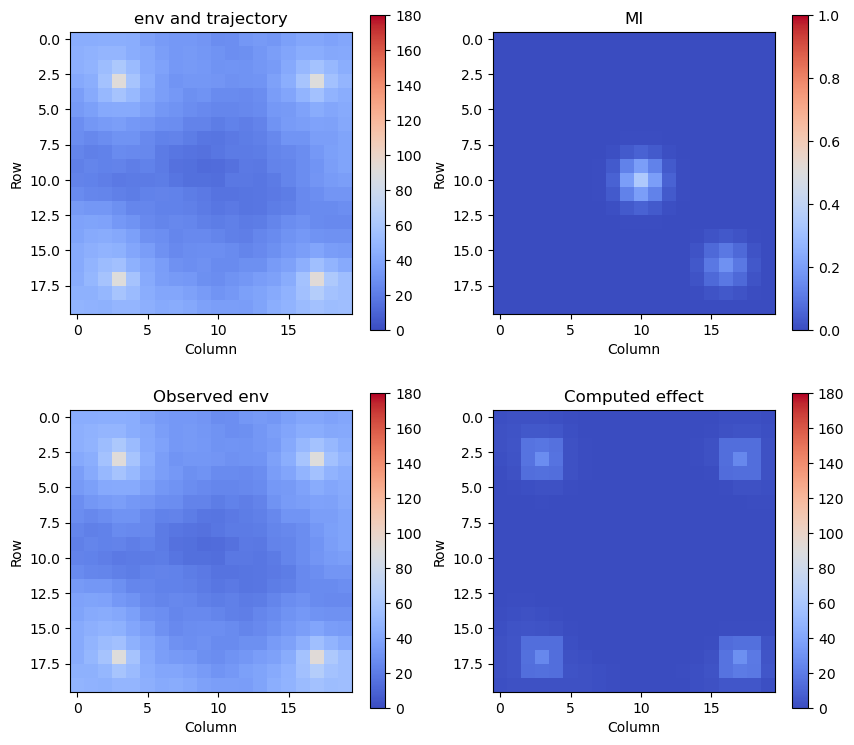

In [15]:
from pypolo2.experiments import visualizer
ani = visualizer.visual(logger)

# Display the animation
from IPython.display import HTML
HTML(ani.to_jshtml())

In [16]:
import math
import numpy as np
Temp = 1
k = math.pow(0.00002, 1 / 10)
k = math.pow(k, 3)
delta_e_2 = -0.1
accept_prob = np.exp(delta_e_2 / (k * Temp))
print(k)
print(accept_prob)

0.03893220474761734
0.07664525292497093


In [17]:
numbers = rng.randint(0, 19, size=10)
pairs = rng.choice(numbers, size=(5, 2), replace=False)
print(pairs)

[[ 7 12]
 [15 10]
 [ 9 13]
 [ 1 14]
 [12 11]]


In [18]:
Setting.RR

array([[  9,   2, 253],
       [ 18,  16, 179],
       [  4,  17, 202]])